In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from nbodykit.lab import *
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy.stats import wasserstein_distance

from nbodykit import setup_logging
setup_logging()

y_test = pd.read_csv('../data/splited/y_test.csv')
X_test = pd.read_csv('../data/splited/X_test.csv')

# Paper data load

In [2]:
output_paper = pd.read_csv('output_paper.csv')

output_paper = pd.concat([y_test[['X_h', 'Y_h', 'Z_h']], output_paper], axis=1)

# Model load

## Aux func

In [3]:
class customLossYan(nn.Module):
    def __init__(self, quantiles):
        super(customLossYan, self).__init__()
        self.quantiles = quantiles

    def forward(self, y_true, y_pred):
        losses = []
        for i,q in enumerate(self.quantiles):
            #print("predicción: ",y_pred)
            #print("verdad: ",y_true)
            errors = y_true[:,i] - y_pred[:,i]
            losses.append(
                torch.max((q - 1) * errors, q * errors)
            )
        loss = torch.mean(torch.stack(losses).sum(dim=0))
        return loss 

def augment(x, tau=None):
    if tau is None:
        tau = torch.zeros(x.size(0), 1).fill_(0.5)
    elif isinstance(tau, float):
        tau = torch.zeros(x.size(0), 1).fill_(tau)
    return torch.cat((x, (tau - 0.5) * 12), 1)

class QuantileLossHighDim(torch.nn.Module):
    def __init__(self):
        super(QuantileLoss, self).__init__()

    def forward(self, yhat, y, tau):
        diff = yhat - y
        mask = (diff.ge(0).float() - tau).detach()
        return (mask * diff).mean(dim=1).mean()

class QuantileLossWess(nn.Module):
    def __init__(self):
        super(QuantileLoss, self).__init__()

    def forward(self, yhat, y, tau):
        diff = yhat - y
        mask = (diff.ge(0).float() - tau).detach()
        quantile_loss = (mask * diff).mean(dim=1).mean()
        distribution_penalty_value = distribution_penalty(y, yhat)

        total_loss = quantile_loss + distribution_penalty_value
        return total_loss

def distribution_penalty(y_true, y_pred):
    # Convertir los tensores a numpy para el cálculo
    y_true_np = y_true.detach().numpy()
    y_pred_np = y_pred.detach().numpy()
    
    # Histograma de la propiedad que deseas comparar (ej. stellar_mass)
    hist_true, bin_edges = np.histogram(y_true_np[:, 0], bins=50, density=True)
    hist_pred, _ = np.histogram(y_pred_np[:, 0], bins=bin_edges, density=True)
    
    # Calcular la distancia de Wasserstein entre las distribuciones
    wasserstein_penalty = wasserstein_distance(hist_true, hist_pred)
    
    return wasserstein_penalty

## Model load

In [4]:
class HaloToGalaxyModel(nn.Module):
    def __init__(self, input_size=4, output_size=1, hidden_dim=64):
        super(HaloToGalaxyModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_dim) 
        self.fc2 = nn.Linear(hidden_dim, hidden_dim) 
        self.fc3 = nn.Linear(hidden_dim, output_size)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  
        return x

In [5]:
file_path = 'datasetcompleto.csv'  
data = pd.read_csv(file_path)
X = data.iloc[:, 5:10].values

In [6]:
hidden_dim = 100 #tamaño de las capas ocultas

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [8]:
model_smass = HaloToGalaxyModel(X.shape[1], 3, hidden_dim).to(device)
model_smass.load_state_dict(torch.load('StellarMass.pth'))

optimizer = torch.optim.AdamW(model_smass.parameters(), lr=1e-3, weight_decay=1e-2)

/tmp/ipykernel_151812/1661172795.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_smass.load_state_dict(torch.load('StellarMass.pth'))


In [9]:
model_smass_color = HaloToGalaxyModel(X.shape[1], 6, hidden_dim).to(device)

model_smass_color.load_state_dict(torch.load('masaycolor.pth'))

optimizer = torch.optim.AdamW(model_smass_color.parameters(), lr=1e-3, weight_decay=1e-2)

/tmp/ipykernel_151812/2485483743.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_smass_color.load_state_dict(torch.load('masaycolor.pth'))


In [10]:
model_color = HaloToGalaxyModel(X.shape[1], 3, hidden_dim).to(device)

model_color.load_state_dict(torch.load('color1.pth'))

optimizer = torch.optim.AdamW(model_color.parameters(), lr=1e-3, weight_decay=1e-2)

/tmp/ipykernel_151812/3893493167.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_color.load_state_dict(torch.load('color1.pth'))


model_smass_color_wass = HaloToGalaxyModel(6, 2, hidden_dim)

checkpoint = torch.load('../models/smass-color-g-i-wass-smogn_model.pth')

model_smass_color_wass.load_state_dict(checkpoint['model_state_dict'])

optimizer = torch.optim.AdamW(model_smass_color_wass.parameters(), lr=1e-3, weight_decay=1e-2)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Model predict

In [11]:
train_dev, test = train_test_split(data, test_size=0.15, random_state=42)

In [12]:
X_test = test.iloc[:, 5:10].values

In [13]:
scaler = StandardScaler()
X_test = scaler.fit_transform(X_test)

In [14]:
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)

In [15]:
model_smass.eval()
with torch.no_grad():
    #taus = torch.rand(X_test.size(0), 1)
    #augmented_x = augment(X_test, taus).to(device)
    #print(augmented_x)
    
    y_pred_smass = model_smass(X_test)
    y_pred_smass = y_pred_smass[:,1].unsqueeze(1)


In [16]:
print(y_pred_smass)

tensor([[-6.2853],
        [-4.8599],
        [-4.9689],
        ...,
        [-5.7967],
        [-3.4570],
        [-4.6674]], device='cuda:0')


In [17]:
model_color.eval()
with torch.no_grad():
    #taus = torch.rand(X_test.size(0), 1)
    #augmented_x = augment(X_test, taus)
    
    y_pred_color = model_color(X_test)
    y_pred_color = y_pred_color[:,1].unsqueeze(1)

In [18]:
print(y_pred_color)

tensor([[0.1873],
        [0.2992],
        [0.2214],
        ...,
        [0.2563],
        [0.5997],
        [0.3429]], device='cuda:0')


In [19]:
model_smass_color.eval()
with torch.no_grad():
    #taus = torch.rand(X_test.size(0), 1)
    #augmented_x = augment(X_test, taus)
    
    y_pred_smass_color = model_smass_color(X_test)
    y_pred_smass_color1 = y_pred_smass_color[:,1].unsqueeze(1)
    y_pred_smass_color2 = y_pred_smass_color[:,4].unsqueeze(1)
    y_pred_smass_color = torch.cat((y_pred_smass_color1,y_pred_smass_color2),dim=1)

In [20]:
print(y_pred_smass_color)

tensor([[3.7926, 1.5568],
        [4.5638, 1.5204],
        [4.2747, 1.6262],
        ...,
        [4.1250, 1.6632],
        [6.0891, 1.5233],
        [4.8662, 1.5610]], device='cuda:0')


# Dataframe constr

In [21]:
y_pred_smass_color_union = torch.cat((y_pred_smass,y_pred_color), dim=1)
output_paper = pd.concat([test[['X_h', 'Y_h', 'Z_h']], output_paper], axis=1)

In [22]:
df_smass_color_joint = pd.DataFrame(y_pred_smass_color, columns=['stellar_mass', 'color_g_i'])
df_smass_color_union = pd.DataFrame(y_pred_smass_color_union, columns=['stellar_mass', 'color_g_i'])
df_smass_color_joint.index = test.index
df_smass_color_union.index = test.index

In [23]:
df_smass_color_joint = pd.concat([test[['X_h', 'Y_h', 'Z_h']], df_smass_color_joint], axis=1)
df_smass_color_union = pd.concat([test[['X_h', 'Y_h', 'Z_h']], df_smass_color_union], axis=1)


In [24]:
print(df_smass_color_union)

               X_h         Y_h        Z_h                      stellar_mass  \
61793   160.653320  122.446190  163.55624  tensor(-6.2853, device='cuda:0')   
108395  135.672650  184.612440  170.99774  tensor(-4.8599, device='cuda:0')   
93486   185.607590  102.017080  139.19798  tensor(-4.9689, device='cuda:0')   
14831    39.080486  128.021710  134.30380  tensor(-3.6490, device='cuda:0')   
88315    38.594670  165.916750  165.71620  tensor(-3.9909, device='cuda:0')   
...            ...         ...        ...                               ...   
60465    55.348164   22.199759  174.89217  tensor(-5.0953, device='cuda:0')   
58815    69.991516   65.799070   36.68525  tensor(-5.6849, device='cuda:0')   
57495    31.297653   47.501804  127.84730  tensor(-5.7967, device='cuda:0')   
23598    62.133320  115.167625  139.94716  tensor(-3.4570, device='cuda:0')   
117986   47.422928   97.077980   84.72807  tensor(-4.6674, device='cuda:0')   

                              color_g_i  
61793   t

# Power spectrum

In [25]:
def tracers_definer(df):
    tracers = {
        1: df[(df['color_g_i'] > 1.05) & (df['stellar_mass'].between(9.5, 10.5))],
        2: df[(df['color_g_i'] > 1.05) & (df['stellar_mass'] > 10.5)],
        3: df[(df['color_g_i'].between(0.80, 1.05)) & (df['stellar_mass'] <= 9.5)],
        4: df[(df['color_g_i'].between(0.80, 1.05)) & (df['stellar_mass'].between(9.5, 10.5))],
        5: df[(df['color_g_i'].between(0.80, 1.05)) & (df['stellar_mass'] > 10.5)],
        6: df[(df['color_g_i'] <= 0.80) & (df['stellar_mass'] <= 9.5)],
        7: df[(df['color_g_i'] <= 0.80) & (df['stellar_mass'].between(9.5, 10.5))]
    }
    return tracers

In [26]:
tracers = tracers_definer(test)
tracers_smass_color_joint = tracers_definer(df_smass_color_joint)
tracers_smass_color_union = tracers_definer(df_smass_color_union)
tracers_paper = tracers_definer(output_paper)

In [27]:
print("Cantidad de objetos por trazador original")
for i in range(1, 8):
    print(f'Trazador {i}: {len(tracers[i])} objetos')


Cantidad de objetos por trazador original
Trazador 1: 1497 objetos
Trazador 2: 1942 objetos
Trazador 3: 1777 objetos
Trazador 4: 2300 objetos
Trazador 5: 482 objetos
Trazador 6: 11172 objetos
Trazador 7: 6908 objetos


In [28]:
print("Cantidad de objetos por trazador predicción conjunta")
for i in range(1, 8):
    print(f'Trazador {i}: {len(tracers_smass_color_joint[i])} objetos')


Cantidad de objetos por trazador predicción conjunta
Trazador 1: 4 objetos
Trazador 2: 11 objetos
Trazador 3: 428 objetos
Trazador 4: 0 objetos
Trazador 5: 0 objetos
Trazador 6: 129 objetos
Trazador 7: 0 objetos


In [29]:
print("Cantidad de objetos por trazador predicción unida")
for i in range(1, 8):
    print(f'Trazador {i}: {len(tracers_smass_color_union[i])} objetos')


Cantidad de objetos por trazador predicción unida
Trazador 1: 0 objetos
Trazador 2: 0 objetos
Trazador 3: 8 objetos
Trazador 4: 0 objetos
Trazador 5: 0 objetos
Trazador 6: 26208 objetos
Trazador 7: 0 objetos


print("Cantidad de objetos por trazador predicción conjunta + Wasserstein")
for i in range(1, 8):
    print(f'Trazador {i}: {len(tracers_smass_color_joint_wass[i])} objetos')


In [30]:
print("Cantidad de objetos por trazador del paper")
for i in range(1, 8):
    print(f'Trazador {i}: {len(tracers_paper[i])} objetos')

Cantidad de objetos por trazador del paper
Trazador 1: 3463 objetos
Trazador 2: 3651 objetos
Trazador 3: 3754 objetos
Trazador 4: 4432 objetos
Trazador 5: 626 objetos
Trazador 6: 22436 objetos
Trazador 7: 13565 objetos


In [31]:
# Función para calcular el espectro de potencia de un trazador dado
def calculate_power_spectrum(tracer_df):
    # Obtener posiciones de los halos
    positions = tracer_df[['X_h', 'Y_h', 'Z_h']].values #Para el original deben ser los de las galaxias reales
    # Crear un catálogo de nbodykit con las posiciones
    cat = ArrayCatalog({'Position': positions}, BoxSize=[205.0, 205.0, 205.0])
    # Convertir el catálogo a una malla
    mesh = cat.to_mesh(Nmesh=256, window='tsc')
    # Calcular el espectro de potencia 1D
    r = FFTPower(mesh, mode='1d')
    power = r.power
    # Obtener los valores de k y P(k)
    k = power['k']
    pk = power['power'].real - power.attrs['shotnoise']
    return k, pk

In [32]:
# Calcular los espectros de potencia para cada trazador
power_spectra = {}
for alpha, df in tracers.items():
    k, pk = calculate_power_spectrum(df)
    power_spectra[alpha] = (k, pk)

/tmp/ipykernel_151812/2380800607.py:8: DeprecationWarning: The window argument is deprecated. Use `resampler=` instead
  mesh = cat.to_mesh(Nmesh=256, window='tsc')
[ 000185.35 ]   0: 08-02 00:57  CatalogMesh     INFO     Chunk 0 ~ 4194304 / 1497 
[ 000185.50 ]   0: 08-02 00:57  CatalogMesh     INFO     painted 1497 out of 1497 objects to mesh
[ 000185.51 ]   0: 08-02 00:57  CatalogMesh     INFO     painted 1497 out of 1497 objects to mesh
[ 000185.51 ]   0: 08-02 00:57  CatalogMesh     INFO     mean particles per cell is 8.92282e-05
[ 000185.51 ]   0: 08-02 00:57  CatalogMesh     INFO     sum is 1497 
[ 000185.53 ]   0: 08-02 00:57  CatalogMesh     INFO     normalized the convention to 1 + delta
[ 000185.69 ]   0: 08-02 00:57  CatalogMesh     INFO     field: (ArrayCatalog(size=1497) as CatalogMesh) painting done
[ 000186.23 ]   0: 08-02 00:57  CatalogMesh     INFO     Chunk 0 ~ 4194304 / 1942 
[ 000186.34 ]   0: 08-02 00:57  CatalogMesh     INFO     painted 1942 out of 1942 objects to

In [33]:
print(power_spectra)

{1: (array([0.02627116, 0.05048589, 0.08050463, 0.10826641, 0.13613543,
       0.16867941, 0.19997246, 0.22921651, 0.26072206, 0.29128432,
       0.32079146, 0.35135855, 0.38269735, 0.41400934, 0.44406926,
       0.4742447 , 0.50509785, 0.53603047, 0.5666569 , 0.5970769 ,
       0.62809344, 0.6586264 , 0.68877122, 0.71965811, 0.75047825,
       0.78115645, 0.81213452, 0.8428755 , 0.87329064, 0.90373173,
       0.93412751, 0.96488725, 0.99578691, 1.02655989, 1.05714411,
       1.08779867, 1.11843775, 1.14889814, 1.17958623, 1.21024059,
       1.24075913, 1.27150259, 1.30222676, 1.33294815, 1.36368808,
       1.39434257, 1.42484916, 1.45538309, 1.48605551, 1.51677835,
       1.54752271, 1.57824068, 1.60896451, 1.63973252, 1.67018988,
       1.700761  , 1.73147907, 1.76198725, 1.7926045 , 1.82324501,
       1.85398766, 1.88467709, 1.91528726, 1.94605975, 1.9766611 ,
       2.00735872, 2.03800631, 2.0685072 , 2.09933017, 2.13002152,
       2.16050163, 2.19106854, 2.22169295, 2.25250995, 2.

In [34]:
# Calcular los espectros de potencia para cada trazador
power_spectra_joint = {}
for alpha, df in tracers_smass_color_joint.items():
    k, pk = calculate_power_spectrum(df)
    power_spectra_joint[alpha] = (k, pk)

/tmp/ipykernel_151812/2380800607.py:8: DeprecationWarning: The window argument is deprecated. Use `resampler=` instead
  mesh = cat.to_mesh(Nmesh=256, window='tsc')
[ 000191.05 ]   0: 08-02 00:57  CatalogMesh     INFO     Chunk 0 ~ 4194304 / 4 
[ 000191.16 ]   0: 08-02 00:57  CatalogMesh     INFO     painted 4 out of 4 objects to mesh
[ 000191.17 ]   0: 08-02 00:57  CatalogMesh     INFO     painted 4 out of 4 objects to mesh
[ 000191.17 ]   0: 08-02 00:57  CatalogMesh     INFO     mean particles per cell is 2.38419e-07
[ 000191.17 ]   0: 08-02 00:57  CatalogMesh     INFO     sum is 4 
[ 000191.18 ]   0: 08-02 00:57  CatalogMesh     INFO     normalized the convention to 1 + delta
[ 000191.32 ]   0: 08-02 00:57  CatalogMesh     INFO     field: (ArrayCatalog(size=4) as CatalogMesh) painting done
[ 000191.85 ]   0: 08-02 00:57  CatalogMesh     INFO     Chunk 0 ~ 4194304 / 11 
[ 000191.95 ]   0: 08-02 00:57  CatalogMesh     INFO     painted 11 out of 11 objects to mesh
[ 000191.95 ]   0: 08

In [35]:
 print(power_spectra_joint)

{1: (array([0.02627116, 0.05048589, 0.08050463, 0.10826641, 0.13613543,
       0.16867941, 0.19997246, 0.22921651, 0.26072206, 0.29128432,
       0.32079146, 0.35135855, 0.38269735, 0.41400934, 0.44406926,
       0.4742447 , 0.50509785, 0.53603047, 0.5666569 , 0.5970769 ,
       0.62809344, 0.6586264 , 0.68877122, 0.71965811, 0.75047825,
       0.78115645, 0.81213452, 0.8428755 , 0.87329064, 0.90373173,
       0.93412751, 0.96488725, 0.99578691, 1.02655989, 1.05714411,
       1.08779867, 1.11843775, 1.14889814, 1.17958623, 1.21024059,
       1.24075913, 1.27150259, 1.30222676, 1.33294815, 1.36368808,
       1.39434257, 1.42484916, 1.45538309, 1.48605551, 1.51677835,
       1.54752271, 1.57824068, 1.60896451, 1.63973252, 1.67018988,
       1.700761  , 1.73147907, 1.76198725, 1.7926045 , 1.82324501,
       1.85398766, 1.88467709, 1.91528726, 1.94605975, 1.9766611 ,
       2.00735872, 2.03800631, 2.0685072 , 2.09933017, 2.13002152,
       2.16050163, 2.19106854, 2.22169295, 2.25250995, 2.

In [36]:
# Calcular los espectros de potencia para cada trazador
power_spectra_union = {}
for alpha, df in tracers_smass_color_union.items():
    k, pk = calculate_power_spectrum(df)
    power_spectra_union[alpha] = (k, pk)

/tmp/ipykernel_151812/2380800607.py:8: DeprecationWarning: The window argument is deprecated. Use `resampler=` instead
  mesh = cat.to_mesh(Nmesh=256, window='tsc')
[ 000196.37 ]   0: 08-02 00:58  CatalogMesh     INFO     painted 0 out of 0 objects to mesh
[ 000196.37 ]   0: 08-02 00:58  CatalogMesh     INFO     mean particles per cell is 0
[ 000196.37 ]   0: 08-02 00:58  CatalogMesh     INFO     sum is 0 
[ 000196.38 ]   0: 08-02 00:58  CatalogMesh     INFO     normalized the convention to 1 + delta
[ 000196.51 ]   0: 08-02 00:58  CatalogMesh     INFO     field: (ArrayCatalog(size=0) as CatalogMesh) painting done
[ 000197.05 ]   0: 08-02 00:58  CatalogMesh     INFO     painted 0 out of 0 objects to mesh
[ 000197.05 ]   0: 08-02 00:58  CatalogMesh     INFO     mean particles per cell is 0
[ 000197.05 ]   0: 08-02 00:58  CatalogMesh     INFO     sum is 0 
[ 000197.06 ]   0: 08-02 00:58  CatalogMesh     INFO     normalized the convention to 1 + delta
[ 000197.19 ]   0: 08-02 00:58  Catal

In [37]:
print(power_spectra_union)

{1: (array([0.02627116, 0.05048589, 0.08050463, 0.10826641, 0.13613543,
       0.16867941, 0.19997246, 0.22921651, 0.26072206, 0.29128432,
       0.32079146, 0.35135855, 0.38269735, 0.41400934, 0.44406926,
       0.4742447 , 0.50509785, 0.53603047, 0.5666569 , 0.5970769 ,
       0.62809344, 0.6586264 , 0.68877122, 0.71965811, 0.75047825,
       0.78115645, 0.81213452, 0.8428755 , 0.87329064, 0.90373173,
       0.93412751, 0.96488725, 0.99578691, 1.02655989, 1.05714411,
       1.08779867, 1.11843775, 1.14889814, 1.17958623, 1.21024059,
       1.24075913, 1.27150259, 1.30222676, 1.33294815, 1.36368808,
       1.39434257, 1.42484916, 1.45538309, 1.48605551, 1.51677835,
       1.54752271, 1.57824068, 1.60896451, 1.63973252, 1.67018988,
       1.700761  , 1.73147907, 1.76198725, 1.7926045 , 1.82324501,
       1.85398766, 1.88467709, 1.91528726, 1.94605975, 1.9766611 ,
       2.00735872, 2.03800631, 2.0685072 , 2.09933017, 2.13002152,
       2.16050163, 2.19106854, 2.22169295, 2.25250995, 2.

# Calcular los espectros de potencia para cada trazador
power_spectra_joint_wass = {}
for alpha, df in tracers_smass_color_joint_wass.items():
    k, pk = calculate_power_spectrum(df)
    power_spectra_joint_wass[alpha] = (k, pk)

In [38]:
# Calcular los espectros de potencia para cada trazador
power_spectra_paper = {}
for alpha, df in tracers_paper.items():
    k, pk = calculate_power_spectrum(df)
    power_spectra_paper[alpha] = (k, pk)

/tmp/ipykernel_151812/2380800607.py:8: DeprecationWarning: The window argument is deprecated. Use `resampler=` instead
  mesh = cat.to_mesh(Nmesh=256, window='tsc')
[ 000201.47 ]   0: 08-02 00:58  CatalogMesh     INFO     Chunk 0 ~ 4194304 / 3463 
[ 000260.29 ]   0: 08-02 00:59  CatalogMesh     INFO     painted 3463 out of 3463 objects to mesh
[ 000260.29 ]   0: 08-02 00:59  CatalogMesh     INFO     painted 3463 out of 3463 objects to mesh
[ 000260.30 ]   0: 08-02 00:59  CatalogMesh     INFO     mean particles per cell is 0.000206411
[ 000260.30 ]   0: 08-02 00:59  CatalogMesh     INFO     sum is nan 
[ 000260.31 ]   0: 08-02 00:59  CatalogMesh     INFO     normalized the convention to 1 + delta
[ 000260.44 ]   0: 08-02 00:59  CatalogMesh     INFO     field: (ArrayCatalog(size=3463) as CatalogMesh) painting done
[ 000260.96 ]   0: 08-02 00:59  CatalogMesh     INFO     Chunk 0 ~ 4194304 / 3651 
[ 000322.50 ]   0: 08-02 01:00  CatalogMesh     INFO     painted 3651 out of 3651 objects to 

In [39]:
print(power_spectra_paper)

{1: (array([0.02627116, 0.05048589, 0.08050463, 0.10826641, 0.13613543,
       0.16867941, 0.19997246, 0.22921651, 0.26072206, 0.29128432,
       0.32079146, 0.35135855, 0.38269735, 0.41400934, 0.44406926,
       0.4742447 , 0.50509785, 0.53603047, 0.5666569 , 0.5970769 ,
       0.62809344, 0.6586264 , 0.68877122, 0.71965811, 0.75047825,
       0.78115645, 0.81213452, 0.8428755 , 0.87329064, 0.90373173,
       0.93412751, 0.96488725, 0.99578691, 1.02655989, 1.05714411,
       1.08779867, 1.11843775, 1.14889814, 1.17958623, 1.21024059,
       1.24075913, 1.27150259, 1.30222676, 1.33294815, 1.36368808,
       1.39434257, 1.42484916, 1.45538309, 1.48605551, 1.51677835,
       1.54752271, 1.57824068, 1.60896451, 1.63973252, 1.67018988,
       1.700761  , 1.73147907, 1.76198725, 1.7926045 , 1.82324501,
       1.85398766, 1.88467709, 1.91528726, 1.94605975, 1.9766611 ,
       2.00735872, 2.03800631, 2.0685072 , 2.09933017, 2.13002152,
       2.16050163, 2.19106854, 2.22169295, 2.25250995, 2.

In [40]:
""" # Función para calcular los valores de sigma² para cada trazador
def calculate_sigma(tracer_df, pk):
    # Número de trazadores
    n_alpha = len(tracer_df)
    # Volumen de la caja
    volume = 205.0**3
    # Densidad numérica promedio
    n_bar = n_alpha / volume
    k_values = pk[0]
    p_values = pk[1]
    # Delta k (diferencia entre valores consecutivos de k)
    delta_k = k_values[1] - k_values[0]
    # Volumen en el espacio k
    V_k = 4 * np.pi * k_values**2 * delta_k / (2 * np.pi)**3
    # Calcular sigma²
    sigma2_alpha_i = (2 / V_k) * ((1 + n_bar * p_values) / (n_bar * p_values))**2
    return sigma2_alpha_i """

' # Función para calcular los valores de sigma² para cada trazador\ndef calculate_sigma(tracer_df, pk):\n    # Número de trazadores\n    n_alpha = len(tracer_df)\n    # Volumen de la caja\n    volume = 205.0**3\n    # Densidad numérica promedio\n    n_bar = n_alpha / volume\n    k_values = pk[0]\n    p_values = pk[1]\n    # Delta k (diferencia entre valores consecutivos de k)\n    delta_k = k_values[1] - k_values[0]\n    # Volumen en el espacio k\n    V_k = 4 * np.pi * k_values**2 * delta_k / (2 * np.pi)**3\n    # Calcular sigma²\n    sigma2_alpha_i = (2 / V_k) * ((1 + n_bar * p_values) / (n_bar * p_values))**2\n    return sigma2_alpha_i '

In [41]:
def calculate_volume(k_i, bin_width):
    return (4 * np.pi * k_i**2 * bin_width) / (2 * np.pi)**3

def calculate_sigma(tracer_df, p):
    k, pk = p  # Assuming you have k and pk for a tracer
    bin_width = k[1] - k[0]
    num_objects = len(tracer_df)
    V = 205.0**3
    density = num_objects / V
    Vtilde = np.array([calculate_volume(ki, bin_width) for ki in k])
    sigma2 = (pk**2) * (2 / (V * Vtilde)) * ((1 + density * pk) / (density * pk))**2
    return sigma2

In [42]:
sigma_values_joint = {}
for alpha, df in tracers_smass_color_joint.items():
    sigma2_alpha_i = calculate_sigma(df, power_spectra_joint[alpha])
    sigma_values_joint[alpha] = sigma2_alpha_i

In [43]:
sigma_values_union = {}
for alpha, df in tracers_smass_color_union.items():
    sigma2_alpha_i = calculate_sigma(df, power_spectra_union[alpha])
    sigma_values_union[alpha] = sigma2_alpha_i

sigma_values_joint_wass = {}
for alpha, df in tracers_smass_color_joint_wass.items():
    sigma2_alpha_i = calculate_sigma(df, power_spectra_joint_wass[alpha])
    sigma_values_joint_wass[alpha] = sigma2_alpha_i

In [44]:
# Calcular los valores de sigma² para cada trazador
sigma_values_paper = {}
for alpha, df in tracers_paper.items():
    sigma2_alpha_i = calculate_sigma(df, power_spectra_paper[alpha])
    sigma_values_paper[alpha] = sigma2_alpha_i

In [45]:
# Calcular los valores de sigma² para cada trazador
sigma_values = {}
for alpha, df in tracers.items():
    sigma2_alpha_i = calculate_sigma(df, power_spectra[alpha])
    sigma_values[alpha] = sigma2_alpha_i

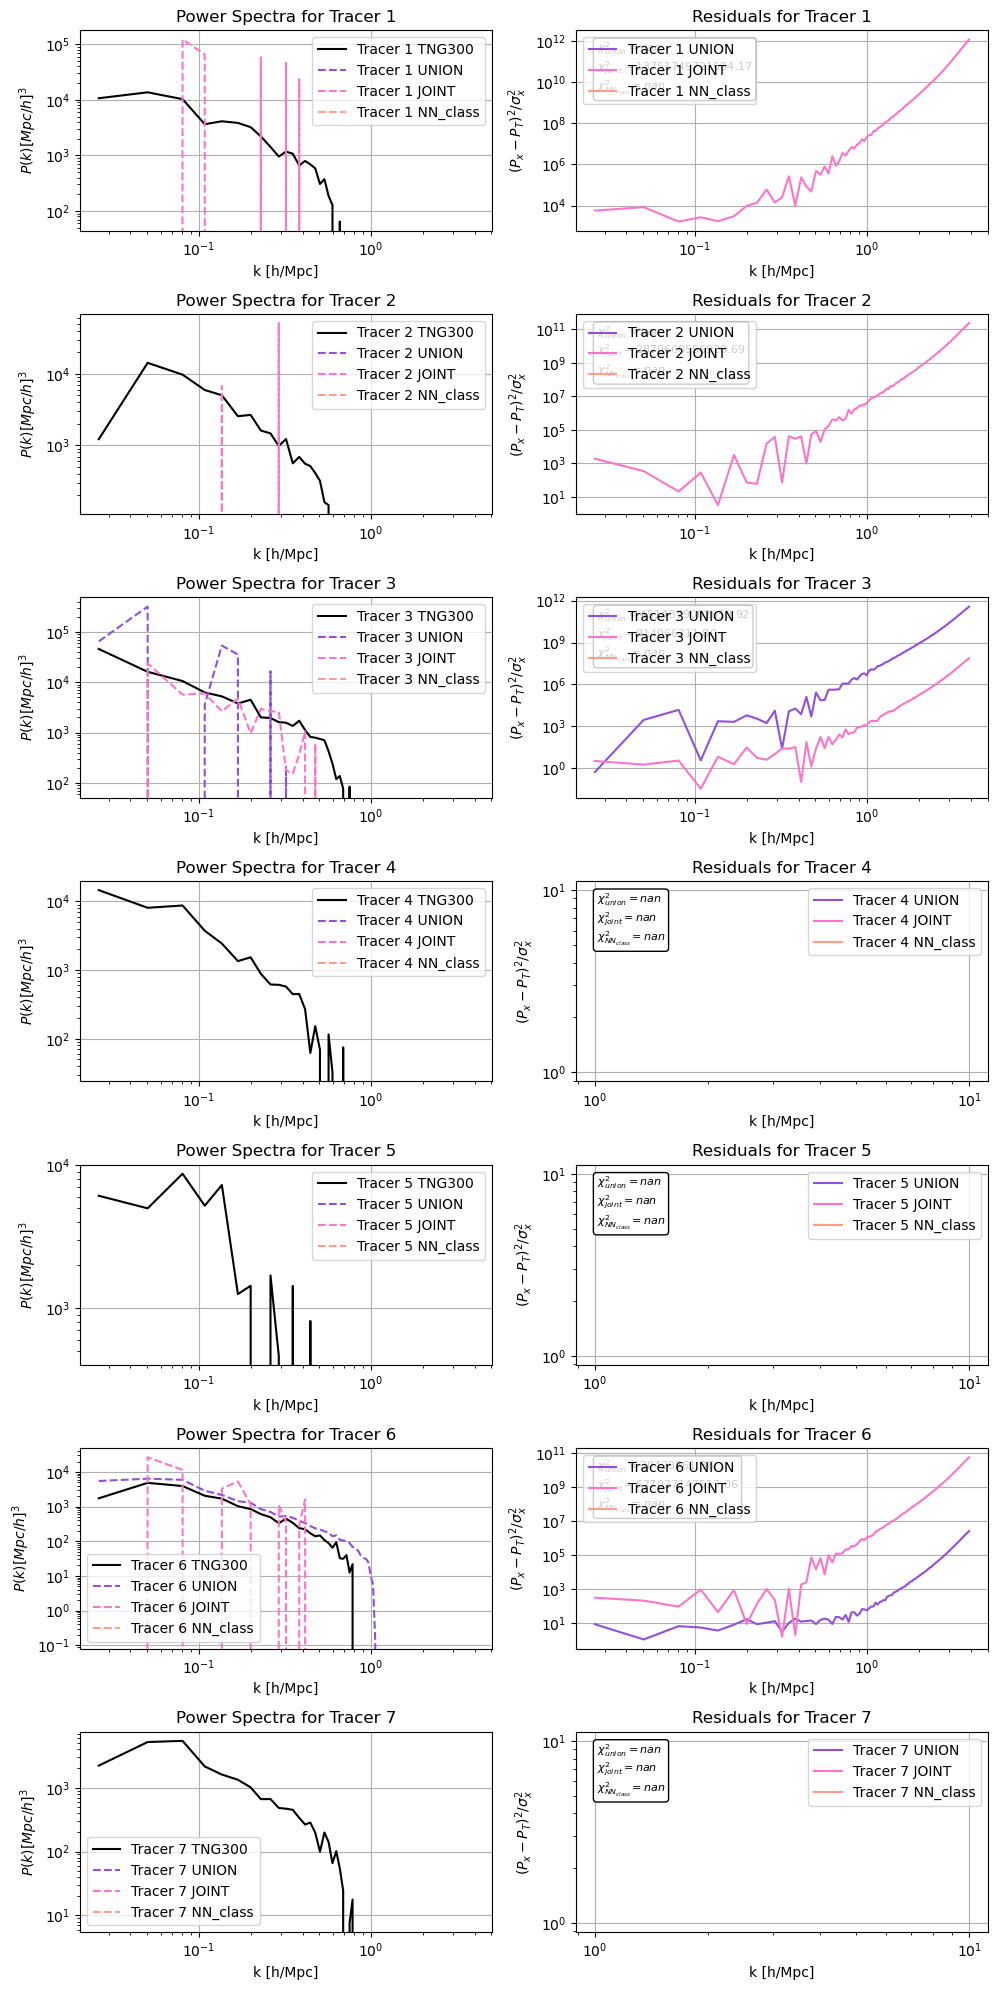

In [46]:
# Crear una figura grande con subgráficos organizados en una cuadrícula
fig, axs = plt.subplots(7, 2, figsize=(10, 20), facecolor='white')

for i, alpha in enumerate(range(1, 8)):
    # Subgráfico 1: P(k) vs k
    k, pk_tng300 = power_spectra[alpha]
    k_union, pk_union = power_spectra_union[alpha]
    k_joint, pk_joint = power_spectra_joint[alpha]
    #k_joint_wass, pk_joint_wass = power_spectra_joint_wass[alpha]
    k_paper, pk_paper = power_spectra_paper[alpha]
    
    axs[i, 0].plot(k, pk_tng300, label=f'Tracer {alpha} TNG300', color='#000000')
    axs[i, 0].plot(k_union, pk_union, label=f'Tracer {alpha} UNION', linestyle='--', color='#924fdc')
    axs[i, 0].plot(k_joint, pk_joint, label=f'Tracer {alpha} JOINT', linestyle='--', color='#fd75ca')
    #axs[i, 0].plot(k_joint_wass, pk_joint_wass, label=f'Tracer {alpha} JOINT Wasserstein', linestyle='--', color='#2bffd2')
    axs[i, 0].plot(k_paper, pk_paper, label=f'Tracer {alpha} NN_class', linestyle='--', color='#ff9e8b')
    
    axs[i, 0].set_xlabel('k [h/Mpc]')
    axs[i, 0].set_ylabel(r'$P(k) [Mpc/h]^3$')
    axs[i, 0].set_xscale('log')
    axs[i, 0].set_yscale('log')
    axs[i, 0].set_title(f'Power Spectra for Tracer {alpha}')
    axs[i, 0].legend()
    axs[i, 0].grid(True)

    ## Establecer los límites de los ejes
    #axs[i, 0].set_xlim(0.08, 0.5)
    #axs[i, 0].set_ylim(1e2, 1e5)
#
    ## Establecer los ticks en los ejes
    #axs[i, 0].set_xticks([0.1, 0.2, 0.4])
    #axs[i, 0].set_xticklabels(['0.1', '0.2', '0.4'])
    #axs[i, 0].set_yticks([1e2, 1e3, 1e4, 1e5])
    #axs[i, 0].set_yticklabels(['1e2', '1e3', '1e4', '1e5'])
    #
    ## Controlar el formato de los ticks en el eje x usando MaxNLocator
    #axs[i, 0].xaxis.set_major_locator(MaxNLocator(integer=False, prune='both'))
    #
    #axs[i, 0].grid(False, which='both', axis='x')
    #
    #for tick in [0.1, 0.2, 0.4]:
    #    axs[i, 0].axvline(x=tick, color='gray', linestyle='--', linewidth=0.7)

    sigma2_alpha_i = sigma_values[alpha]

    residual_union = (pk_union - pk_tng300)**2 / sigma2_alpha_i
    residual_joint = (pk_joint - pk_tng300)**2 / sigma2_alpha_i
    #residual_joint_wass = (pk_joint_wass - pk_tng300)**2 / sigma2_alpha_i
    residual_paper = (pk_paper - pk_tng300)**2 / sigma2_alpha_i
    axs[i, 1].plot(k_union, residual_union, label=f'Tracer {alpha} UNION', color='#924fdc')
    axs[i, 1].plot(k_joint, residual_joint, label=f'Tracer {alpha} JOINT', color='#fd75ca')
    #axs[i, 1].plot(k_joint_wass, residual_joint_wass, label=f'Tracer {alpha} JOINT Wasserstein', color='#2bffd2')
    axs[i, 1].plot(k_paper, residual_paper, label=f'Tracer {alpha} NN_class', color='#ff9e8b')
    

    
    chi2_value_union = np.sum(residual_union)
    chi2_value_joint = np.sum(residual_joint)
    #chi2_value_joint_wass = np.sum(residual_joint_wass)
    chi2_value_paper = np.sum(residual_paper)
    
    # Añadir el valor de chi cuadrado como texto en el gráfico
    table_str = (
        r'$\chi^2_{union} = ' + f'{chi2_value_union:.2f}$' '\n'
        r'$\chi^2_{joint} = ' + f'{chi2_value_joint:.2f}$' '\n'
        #r'$\chi^2_{joint\_wass} = ' + f'{chi2_value_joint_wass:.2f}$' '\n'
        r'$\chi^2_{NN_{class}} = ' + f'{chi2_value_paper:.2f}$'
    )
    axs[i, 1].text(0.05, 0.95, table_str, transform=axs[i, 1].transAxes, fontsize= 8, 
                verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))
    
    axs[i, 1].set_xlabel('k [h/Mpc]')
    axs[i, 1].set_ylabel(r'$(P_x - P_T)^2 / \sigma_x^2$')
    axs[i, 1].set_xscale('log')
    axs[i, 1].set_yscale('log')
    axs[i, 1].set_title(f'Residuals for Tracer {alpha}')
    axs[i, 1].legend()
    axs[i, 1].grid(True)

    #axs[i, 1].set_xlim(0.08, 0.5)
#
    #axs[i, 1].set_xticks([0.1, 0.2, 0.4])
    #axs[i, 1].set_xticklabels(['0.1', '0.2', '0.4'])
#
    #axs[i, 1].xaxis.set_major_locator(MaxNLocator(integer=False, prune='both'))
    #
    #axs[i, 1].grid(False, which='both', axis='x')
    #
    #for tick in [0.1, 0.2, 0.4]:
    #    axs[i, 1].axvline(x=tick, color='gray', linestyle='--', linewidth=0.7)

plt.tight_layout()
plt.show()


/tmp/ipykernel_151812/353058591.py:29: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  axs[i, 0].set_xlim(0.0, 0.5)
/tmp/ipykernel_151812/353058591.py:96: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  axs[i, 1].set_xlim(0.0, 0.5)
/tmp/ipykernel_151812/353058591.py:29: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  axs[i, 0].set_xlim(0.0, 0.5)
/tmp/ipykernel_151812/353058591.py:96: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  axs[i, 1].set_xlim(0.0, 0.5)
/tmp/ipykernel_151812/353058591.py:29: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  axs[i, 0].set_xlim(0.0, 0.5)
/tmp/ipykernel_151812/353058591.py:96: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invali

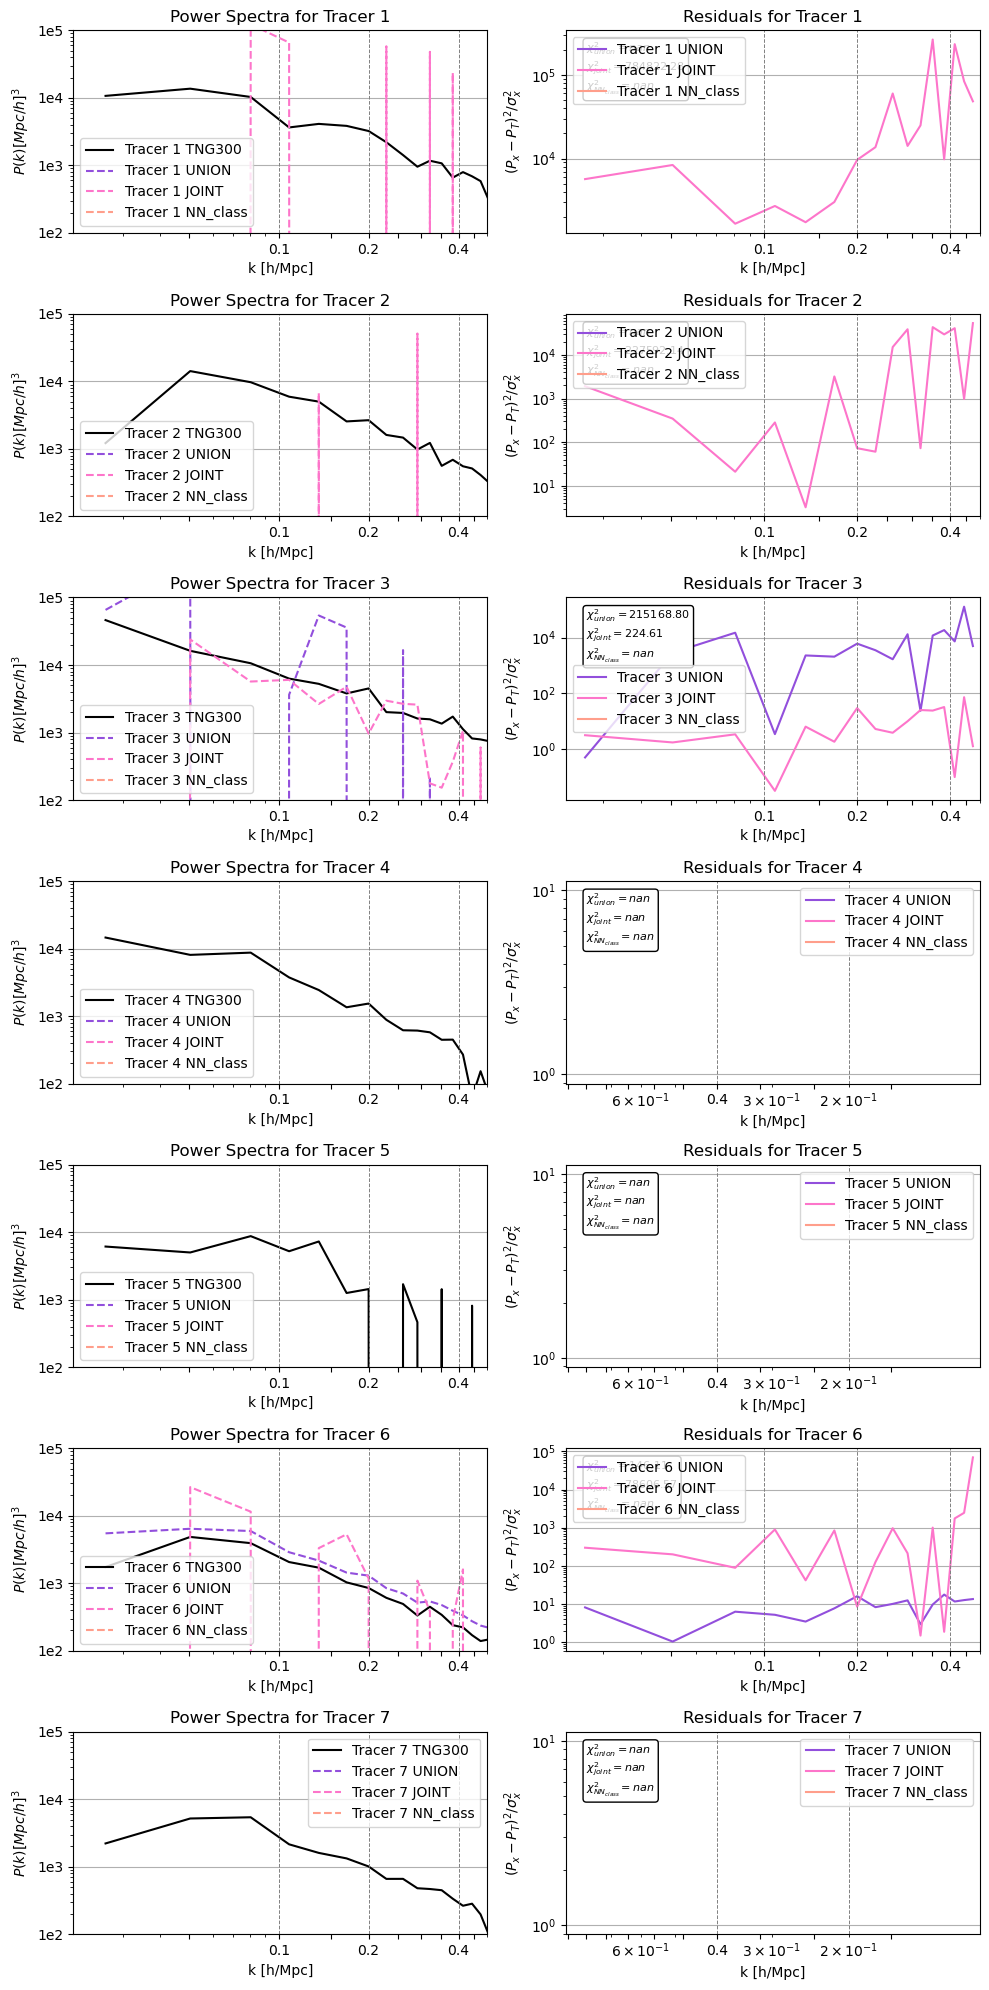

In [47]:
# Crear una figura grande con subgráficos organizados en una cuadrícula
fig, axs = plt.subplots(7, 2, figsize=(10, 20), facecolor='white')

k_min, k_max = 0, 0.5

for i, alpha in enumerate(range(1, 8)):
    # Subgráfico 1: P(k) vs k
    k, pk_tng300 = power_spectra[alpha]
    k_union, pk_union = power_spectra_union[alpha]
    k_joint, pk_joint = power_spectra_joint[alpha]
    #k_joint_wass, pk_joint_wass = power_spectra_joint_wass[alpha]
    k_paper, pk_paper = power_spectra_paper[alpha]
    
    axs[i, 0].plot(k, pk_tng300, label=f'Tracer {alpha} TNG300', color='#000000')
    axs[i, 0].plot(k_union, pk_union, label=f'Tracer {alpha} UNION', linestyle='--', color='#924fdc')
    axs[i, 0].plot(k_joint, pk_joint, label=f'Tracer {alpha} JOINT', linestyle='--', color='#fd75ca')
    #axs[i, 0].plot(k_joint_wass, pk_joint_wass, label=f'Tracer {alpha} JOINT Wasserstein', linestyle='--', color='#2bffd2')
    axs[i, 0].plot(k_paper, pk_paper, label=f'Tracer {alpha} NN_class', linestyle='--', color='#ff9e8b')
    
    axs[i, 0].set_xlabel('k [h/Mpc]')
    axs[i, 0].set_ylabel(r'$P(k) [Mpc/h]^3$')
    axs[i, 0].set_xscale('log')
    axs[i, 0].set_yscale('log')
    axs[i, 0].set_title(f'Power Spectra for Tracer {alpha}')
    axs[i, 0].legend()
    axs[i, 0].grid(True)

    ## Establecer los límites de los ejes
    axs[i, 0].set_xlim(0.0, 0.5)
    axs[i, 0].set_ylim(1e2, 1e5)

    # Establecer los ticks en los ejes
    axs[i, 0].set_xticks([0.1, 0.2, 0.4])
    axs[i, 0].set_xticklabels(['0.1', '0.2', '0.4'])
    axs[i, 0].set_yticks([1e2, 1e3, 1e4, 1e5])
    axs[i, 0].set_yticklabels(['1e2', '1e3', '1e4', '1e5'])
    
    # Controlar el formato de los ticks en el eje x usando MaxNLocator
    axs[i, 0].xaxis.set_major_locator(MaxNLocator(integer=False, prune='both'))
    
    axs[i, 0].grid(False, which='both', axis='x')
    
    for tick in [0.1, 0.2, 0.4]:
        axs[i, 0].axvline(x=tick, color='gray', linestyle='--', linewidth=0.7)

    sigma2_alpha_i = sigma_values[alpha]

    mask = (k >= k_min) & (k <= k_max)
    k_union_filtered = k_union[mask]
    k_joint_filtered = k_joint[mask]
    #k_joint_wass_filtered = k_joint_wass[mask]
    k_paper_filtered = k_paper[mask]

    pk_tng300_filtered = pk_tng300[mask]
    pk_joint_filtered = pk_joint[mask]
    pk_union_filtered = pk_union[mask]
    #pk_joint_wass_filtered = pk_joint_wass[mask]
    pk_paper_filtered = pk_paper[mask]
    sigma2_alpha_i_filtered = sigma2_alpha_i[mask]


    residual_union = (pk_union_filtered - pk_tng300_filtered)**2 / sigma2_alpha_i_filtered
    residual_joint = (pk_joint_filtered - pk_tng300_filtered)**2 / sigma2_alpha_i_filtered
    #residual_joint_wass = (pk_joint_wass_filtered - pk_tng300_filtered)**2 / sigma2_alpha_i_filtered
    residual_paper = (pk_paper_filtered - pk_tng300_filtered)**2 / sigma2_alpha_i_filtered
    axs[i, 1].plot(k_union_filtered, residual_union, label=f'Tracer {alpha} UNION', color='#924fdc')
    axs[i, 1].plot(k_joint_filtered, residual_joint, label=f'Tracer {alpha} JOINT', color='#fd75ca')
    #axs[i, 1].plot(k_joint_wass_filtered, residual_joint_wass, label=f'Tracer {alpha} JOINT Wasserstein', color='#2bffd2')
    axs[i, 1].plot(k_paper_filtered, residual_paper, label=f'Tracer {alpha} NN_class', color='#ff9e8b')
    

    
    chi2_value_union = np.sum(residual_union)
    chi2_value_joint = np.sum(residual_joint)
    #chi2_value_joint_wass = np.sum(residual_joint_wass)
    chi2_value_paper = np.sum(residual_paper)
    
    # Añadir el valor de chi cuadrado como texto en el gráfico
    table_str = (
        r'$\chi^2_{union} = ' + f'{chi2_value_union:.2f}$' '\n'
        r'$\chi^2_{joint} = ' + f'{chi2_value_joint:.2f}$' '\n'
        #r'$\chi^2_{joint\_wass} = ' + f'{chi2_value_joint_wass:.2f}$' '\n'
        r'$\chi^2_{NN_{class}} = ' + f'{chi2_value_paper:.2f}$'
    )
    axs[i, 1].text(0.05, 0.95, table_str, transform=axs[i, 1].transAxes, fontsize= 8, 
                verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))
    
    axs[i, 1].set_xlabel('k [h/Mpc]')
    axs[i, 1].set_ylabel(r'$(P_x - P_T)^2 / \sigma_x^2$')
    axs[i, 1].set_xscale('log')
    axs[i, 1].set_yscale('log')
    axs[i, 1].set_title(f'Residuals for Tracer {alpha}')
    axs[i, 1].legend()
    axs[i, 1].grid(True)

    axs[i, 1].set_xlim(0.0, 0.5)

    axs[i, 1].set_xticks([0.1, 0.2, 0.4])
    axs[i, 1].set_xticklabels(['0.1', '0.2', '0.4'])

    axs[i, 1].xaxis.set_major_locator(MaxNLocator(integer=False, prune='both'))
    
    axs[i, 1].grid(False, which='both', axis='x')
    
    for tick in [0.1, 0.2, 0.4]:
        axs[i, 1].axvline(x=tick, color='gray', linestyle='--', linewidth=0.7)

plt.tight_layout()
plt.show()


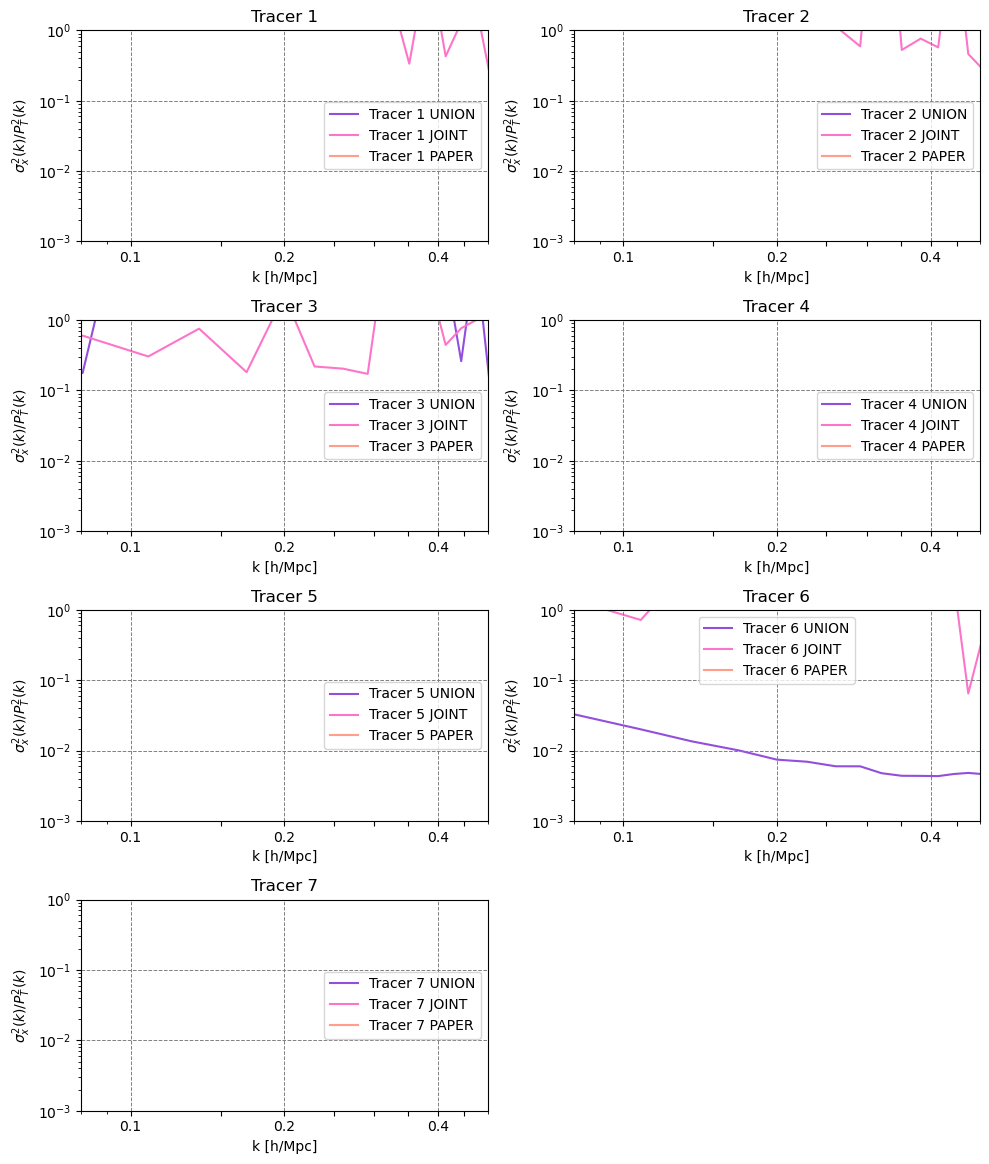

In [48]:
fig, axs = plt.subplots(7, 2, figsize=(10, 20), facecolor='white')  # 7 filas y 2 columnas para mantener la altura

for i, alpha in enumerate(range(1, 8)):
    row, col = divmod(i, 2)  # Calcular la fila y la columna del subgráfico actual

    k_union, pk_union = power_spectra_union[alpha]
    k_joint, pk_joint = power_spectra_joint[alpha]
    #k_joint_wass, pk_joint_wass = power_spectra_joint_wass[alpha]
    k_paper, pk_paper = power_spectra_paper[alpha]

    sigma2_alpha_i_union = sigma_values_union[alpha]
    sigma2_alpha_i_joint = sigma_values_joint[alpha]
    #sigma2_alpha_i_joint_wass = sigma_values_joint_wass[alpha]
    sigma2_alpha_i_paper = sigma_values_paper[alpha]

    ratio_union = sigma2_alpha_i_union / pk_union**2
    ratio_joint = sigma2_alpha_i_joint / pk_joint**2
    #ratio_joint_wass = sigma2_alpha_i_joint_wass / pk_joint_wass**2
    ratio_paper = sigma2_alpha_i_paper / pk_paper**2
    
    # Graficar los datos originales
    axs[row, col].plot(k_union, ratio_union, label=f'Tracer {alpha} UNION', color='#924fdc')
    axs[row, col].plot(k_joint, ratio_joint, label=f'Tracer {alpha} JOINT', color='#fd75ca')
    #axs[row, col].plot(k_joint_wass, ratio_joint_wass, label=f'Tracer {alpha} ALL', color='#2bffd2')
    axs[row, col].plot(k_paper, ratio_paper, label=f'Tracer {alpha} PAPER', color='#ff9e8b')
    
    axs[row, col].set_xlabel('k [h/Mpc]')
    axs[row, col].set_ylabel(r'$\sigma_x^2 (k) / P_T^2 (k)$')
    axs[row, col].set_xscale('log')
    axs[row, col].set_yscale('log')
    axs[row, col].set_title(f'Tracer {alpha}')
    axs[row, col].legend()
    
    axs[row, col].grid(False, which='both', axis='x')
    axs[row, col].set_xlim(0.08, 0.5)
    axs[row, col].set_ylim(1e-3, 1e0)

    # Establecer los ticks en los ejes
    axs[row, col].set_xticks([0.1, 0.2, 0.4])
    axs[row, col].set_xticklabels(['0.1', '0.2', '0.4'])
    axs[row, col].set_yticks([1e-3, 1e-2, 1e-1, 1])
    axs[row, col].set_yticklabels([r'$10^{-3}$', r'$10^{-2}$', r'$10^{-1}$', r'$10^{0}$'])
    
    axs[row, col].xaxis.set_major_locator(MaxNLocator(integer=False, prune='both'))
    
    for tick in [0.1, 0.2, 0.4]:
        axs[row, col].axvline(x=tick, color='gray', linestyle='--', linewidth=0.7)
    
    for tick in [1e-3, 1e-2, 1e-1, 1]:
        axs[row, col].axhline(y=tick, color='gray', linestyle='--', linewidth=0.7)

# Desactivar los subgráficos vacíos
for j in range(i + 1, 7 * 2):  # 7 filas * 2 columnas = 14 subgráficos en total
    fig.delaxes(axs.flat[j])

plt.tight_layout()
plt.show()